# Energy Demand Forecasting - Data Load
Try 1

In [75]:
import traceback
try:
    # psycopg2: python package to deal with a postgres database
    # pip install psycopg2
    import psycopg2
    from psycopg2.extras import execute_values
    
    from datetime import datetime, timedelta
    import numpy as np
    import pandas as pd
    import warnings
    warnings.filterwarnings("ignore", category=Warning)
    # Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
    # In max_columns and max_rows ‘None’ value means unlimited.
    pd.set_option('display.max_rows', 100)
    # Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
    pd.set_option('display.min_rows', 10)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)
    pd.options.display.max_colwidth = 100
    pd.options.display.float_format = '{:.3f}'.format
    
    import urllib.request
    import json
    # Librería para obtener el usuario que está ejecutando el script
    import getpass
except Exception as err:
    formatted_lines = traceback.format_exc().splitlines()
    txt = formatted_lines[1] + '\n' + formatted_lines[-1]
    print('Error Loading packages', '\n', txt)

In [3]:
import os
print('WORKDIR: ' + os.getcwd())

WORKDIR: /home/jovyan/notebooks


In [2]:
print(pd.__version__)

1.5.0


In [24]:
def build_postgres_cnxn(database, host, user, password, port=5432, string_connection=None, verbose=True):
    error_txt = ''
    process_ok = True
    cnxn = None
    cursor = None
    if (not host or not user or not password) and not string_connection:
        process_ok = False
        error_txt = 'ERROR build_postgres_cnxn: Error trying to Build DB connexion: you missed to send host, user or password, or string connection. ' +\
                    ' host: ' + (host if host else 'Missed. ') +\
                    ' user: ' + (user if user else 'Missed.') +\
                    ' password: ' + (password if password else 'Missed.') +\
                    ' String Connection: ' + (string_connection if string_connection else 'Missed.')
        if verbose:
            print(error_txt)
    else:
        if not database:
            if verbose:
                print('WARNING build_postgres_cnxn: no database name provided.')
        try:
            if not string_connection:
                cnxn = psycopg2.connect(database=database, host=host, user=user, password=password, port=port)
            else:
                cnxn = psycopg2.connect(string_connection)
            cursor = cnxn.cursor()
            if verbose:
                print('INFO Module build_postgres_cnxn: DB Connection to host', host, 'Ok')
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            if not string_connection:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database host: ' + host + ' user ' +\
                          user + ' port: ' + str(port) +'\n' + txt)
            else:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database string_connection: ' + string_connection +'\n' + txt)
    return process_ok, error_txt, cnxn, cursor

In [32]:
process_ok, cnxn, cursor = build_postgres_cnxn(database='user', host='local_pgdb', user='user', password='admin', port=5432)

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok


## pg_select_to_pandas

In [3]:
def pg_select_to_pandas(cursor, sql_query, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not cursor or not sql_query):
        process_ok = False
        error_txt = 'ERROR pg_select_to_pandas: No cursor or Query sent as parameter. ' +\
              ' cursor: ' + (' received.' if host else ' missed,') +\
              ' query: ' + (sql_query if sql_query else ' missed.')
        if verbose:
            print(error_txt)
    else:
        try:
            cursor.execute(sql_query)
            data = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=data, columns=colnames)
            if verbose:
                print('INFO pg_select_to_pandas: query executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR pg_select_to_pandas: Error executing query on host: ' + cursor.connection.info.host + ' database ' +\
                  cursor.connection.info.dbname + ' query: ' + sql_query +'\n' + txt
            if verbose:
                print(error_txt)
    return process_ok, error_txt, df

In [8]:
def pg_query_regions_to_pandas(database, host, user, password, port, sql_query):
    process_ok, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port)
    if process_ok:
        process_ok, error_txt, df = pg_select_to_pandas(cursor, sql_query)
        cnxn.close()
    return process_ok, df

In [46]:
sql_query = 'SELECT * FROM cammesa_db."regions"'
process_of, df = pg_query_regions_to_pandas(database='user', host='local_pgdb', user='user', password='admin', port=5432, sql_query=sql_query)
df.head()

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 36


,region_id,region_code,region_desc,parent_id,create_user,create_date,update_user,update_date
0,535042,418,NEA,535052,COLMO,2022-10-23 19:46:15.344908,COLMO,2022-10-23 19:46:15.344910
1,535043,419,NOA,535052,COLMO,2022-10-23 19:46:15.344945,COLMO,2022-10-23 19:46:15.344946
2,535044,426,GBA,535052,COLMO,2022-10-23 19:46:15.344964,COLMO,2022-10-23 19:46:15.344965
3,535045,422,Centro,535052,COLMO,2022-10-23 19:46:15.344982,COLMO,2022-10-23 19:46:15.344983
4,535047,111,Patagonia,535052,COLMO,2022-10-23 19:46:15.344999,COLMO,2022-10-23 19:46:15.345000


## _url_request_to_pandas

In [71]:
def _url_request_to_pandas(_request, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not _request):
        process_ok = False
        error_txt = 'ERROR api_request_to_pandas: No API statement provided.'
        if verbose:
            print(error_txt)
    else:
        try:
            response = urllib.request.urlopen(_request)
            data = response.read()
            encoding = response.info().get_content_charset('utf-8')
            response.close()
            JSON_object = json.loads(data.decode(encoding))
            df = pd.json_normalize(JSON_object)
            if verbose:
                print('INFO api_request_to_pandas: API request executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR api_request_to_pandas: Error requesting API: ' + _request +'\n' + txt
    return process_ok, error_txt, df

In [10]:
date = datetime.now().date()#+timedelta(days=-1)
_request = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegionByFecha?fecha='+str(date)+'&id_region=1002'
process_ok, error_txt, df_demand = _url_request_to_pandas(_request, verbose=True)
df_demand.fecha = pd.to_datetime(df_demand.fecha.astype(str).str[:19], format='%Y-%m-%d %H:%M:%S')
df_demand = df_demand[df_demand.fecha.dt.minute==0]
df_demand

INFO api_request_to_pandas: API request executed Ok. Number of records returned: 221


,fecha,dem,temp
11,2022-10-26 01:00:00,14251,22.100
23,2022-10-26 02:00:00,13623,19.800
35,2022-10-26 03:00:00,13365,19.000
47,2022-10-26 04:00:00,13013,18.600
59,2022-10-26 05:00:00,12983,18.300
71,2022-10-26 06:00:00,13263,18.300
83,2022-10-26 07:00:00,13594,18.200
95,2022-10-26 08:00:00,14670,18.500
107,2022-10-26 09:00:00,15561,19.500
119,2022-10-26 10:00:00,16282,19.500


In [58]:
database='user'
host='local_pgdb'
user='user'
password='admin'
port=5432
verbose = True
process_ok, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port, verbose=verbose)

date = datetime.now().date()+timedelta(days=-1)
_request = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegionByFecha?fecha='+str(date)+'&id_region=1002'
process_ok, error_txt, df_demand = _url_request_to_pandas(_request, verbose=True)
df_demand.fecha = pd.to_datetime(df_demand.fecha.astype(str).str[:19], format='%Y-%m-%d %H:%M:%S')
df_demand = df_demand[df_demand.fecha.dt.minute==0]
if df_demand.shape[0]==0:
    if verbose:
        print('INFO get_hourly_demand - No Data to upsert. Date: ' + str(date))
else:
    # demand values can come as Nan --> exclude those records.
    df_demand.dropna(axis=0, subset=['dem'], inplace=True)
    df_demand.dem = df_demand.dem.astype(int)
    df_demand['day_of_week'] = df_demand.fecha.dt.dayofweek
    process_ok, error_txt, is_a_holiday = is_holiday(date)
    df_demand['is_holiday'] = is_a_holiday
    tup = [tuple(np.append(np.append([1002], r), ['COLMO', datetime.now(), 'COLMO', datetime.now()])) \
                               for r in df_demand.to_numpy()]
    sql = 'INSERT INTO cammesa_db.hourly_demand '+\
                            '(region_code, timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday, create_user, create_date, '+\
                            'update_user, update_date) VALUES %s ON CONFLICT (region_code, timestamp) DO UPDATE '+\
                            'SET hourly_demand=EXCLUDED.hourly_demand, hourly_temp=EXCLUDED.hourly_temp, day_of_week=EXCLUDED.day_of_week, '+\
                            'is_holiday=EXCLUDED.is_holiday, update_user=EXCLUDED.update_user, update_date=EXCLUDED.update_date;'
    execute_values(cursor, sql, tup)
    cnxn.commit()

    print('INFO get_hourly_demand - ' + str(len(tup)) + ' records were upserted. Table cammesa_db.hourly_demand.')

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 288
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 19
INFO is_holiday. URL request for 2022-10-25 Ok.
INFO get_hourly_demand - 24 records were upserted. Table cammesa_db.hourly_demand.


## Holidays
Ver si conviene armar una tabla de feriados, usando la API, que se mantenga diariamente, porque en Argentina se crean feriados cuando quieren
Y se use cuando se cargan datos para colocar si el dato de demanda corresponde a un día feriado o no.

In [72]:
# https://pjnovas.gitbooks.io/no-laborables/content/
# API pública para obtener feriados --> poder indicar una fecha como feriado para utilizar en forecasting.

def is_holiday(date=datetime.now(), verbose=True):
    is_a_holiday = 0
    _request = 'http://nolaborables.com.ar/api/v2/feriados/'+str(date.year)
    process_ok, error_txt, df_holidays = _url_request_to_pandas(_request, verbose)
    if not process_ok:
        if verbose:
            print('ERROR is_holiday. ' + error_txt)
    else:
        is_a_holiday = int(df_holidays[(df_holidays.dia==date.day) & (df_holidays.mes==date.month)].shape[0] > 0)
        if verbose:
            print('INFO is_holiday. URL request for ' + str(date) + ' Ok.')
    return process_ok, error_txt, is_a_holiday

In [30]:
# Test
date = pd.to_datetime(datetime.now())
is_holiday(date, verbose=True)

INFO api_request_to_pandas: API request executed Ok. Number of records returned: 19
INFO is_holiday. URL request for 2022-10-26 02:57:18.002065 Ok.


(True, '', 0)

## get_hourly_demand

In [65]:
#https://stackoverflow.com/questions/8134602/psycopg2-insert-multiple-rows-with-one-query
def get_hourly_demand(date, database, host, user, password, port, verbose=True):
    process_ok = True
    if not date:
        date=datetime.now()
    verbose=True
    error_txt = ''
    process_ok, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port, verbose=verbose)
    if not process_ok:
        if verbose:
            print(error_txt)
    else:
        date = date.date()
        _request = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegionByFecha?fecha='+str(date)+'&id_region=1002'
        process_ok, error_txt, df_demand = _url_request_to_pandas(_request, verbose)
        if not process_ok:
            if verbose:
                print(error_txt)
                cnxn.close()
        else:
            df_demand.fecha = pd.to_datetime(df_demand.fecha.astype(str).str[:19], format='%Y-%m-%d %H:%M:%S')
            df_demand = df_demand[df_demand.fecha.dt.minute==0]
            if df_demand.shape[0]==0:
                if verbose:
                    print('INFO get_hourly_demand - No Data to upsert. Date: ' + str(date))
            else:
                # demand values can come as Nan --> exclude those records.
                df_demand.dropna(axis=0, subset=['dem'], inplace=True)
                df_demand.dem = df_demand.dem.astype(int)
                df_demand['day_of_week'] = df_demand.fecha.dt.dayofweek
                process_ok, error_txt, is_a_holiday = is_holiday(date, verbose=verbose)
                if not process_ok:
                    if verbose:
                        print(error_txt)
                    cnxn.close()
                else:
                    df_demand['is_holiday'] = is_a_holiday
                    tup = [tuple(np.append(np.append([1002], r), ['COLMO', datetime.now(), 'COLMO', datetime.now()])) \
                            for r in df_demand.to_numpy()]
                    sql = 'INSERT INTO cammesa_db.hourly_demand '+\
                        '(region_code, timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday, create_user, create_date, '+\
                        'update_user, update_date) VALUES %s ON CONFLICT (region_code, timestamp) DO UPDATE '+\
                        'SET hourly_demand=EXCLUDED.hourly_demand, hourly_temp=EXCLUDED.hourly_temp, day_of_week=EXCLUDED.day_of_week, '+\
                        'is_holiday=EXCLUDED.is_holiday, update_user=EXCLUDED.update_user, update_date=EXCLUDED.update_date;'
                    execute_values(cursor, sql, tup)
                    cnxn.commit()
                    print('INFO get_hourly_demand - ' + str(len(tup)) + ' records were upserted. Table cammesa_db.hourly_demand.')
        cnxn.close()
    return process_ok

In [66]:
get_hourly_demand(date=pd.to_datetime('2022-10-25'), database='user', host='local_pgdb', user='user', password='admin', port=5432, verbose=True)

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 288
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 19
INFO is_holiday. URL request for 2022-10-25 Ok.
INFO get_hourly_demand - 24 records were upserted. Table cammesa_db.hourly_demand.


True

# Forecasting
# LSTM forecasting
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used to address time-series prediction problem.<br>
Develop a LSTM network for regression, window and time-step based framing of time series prediction problems.
* https://arxiv.org/abs/1507.06947

## LSTMs for Univariate Time Series Forecasting
Problem argentina electricity demand prediction problem. This is a problem where, given a year and a month, the task is to predict the argentinian electricity demand in MWh. The data ranges from January 2012 to May 2022, or almost 12 years, with 125 observations.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

2022-10-28 03:10:38.816357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 03:10:40.069177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 03:10:40.069231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-28 03:10:40.215754: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 03:10:42.264430: W tensorflow/stream_executor/platform/de

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [13]:
datetime.now().date()+timedelta(days=-1)

datetime.date(2022, 10, 26)

In [21]:
# [1] Get historic data: hourly demand till yesterday. Forcasting will start from today
database='user'
host='local_pgdb'
user='user'
password='admin'
port=5432
verbose = True
process_ok, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port, verbose=verbose)
if process_ok:
    date = datetime.now().date()
    sql_query = """SELECT timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday 
                    FROM cammesa_db.hourly_demand 
                    WHERE timestamp <= '""" + date.strftime('%Y-%m-%d') +"'" +\
                """ORDER BY timestamp"""
    process_ok, error_txt, df_hist = pg_select_to_pandas(cursor, sql_query, verbose=True)
    if not process_ok:
        if verbose:
            print('INFO - nombre_de_proceso Error.' + error_txt)
    else:
        df_hist
df_hist.sort_values(by='timestamp')

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 2854


,timestamp,hourly_demand,hourly_temp,day_of_week,is_holiday
0,2022-07-01 01:00:00,17891,8.800,4,0
1,2022-07-01 02:00:00,17206,8.700,4,0
2,2022-07-01 03:00:00,16732,8.900,4,0
3,2022-07-01 04:00:00,16578,8.700,4,0
4,2022-07-01 05:00:00,16607,8.700,4,0
...,...,...,...,...,...
2849,2022-10-27 20:00:00,18092,24.300,3,0
2850,2022-10-27 21:00:00,18322,22.100,3,0
2851,2022-10-27 22:00:00,17656,20.600,3,0
2852,2022-10-27 23:00:00,16551,20.100,3,0


In [22]:
# We are not interested in the date, given that each observation is separated by the same interval (hourly) 
# We build an univariate dataset:
df_hist_univar = df_hist[['hourly_demand']]

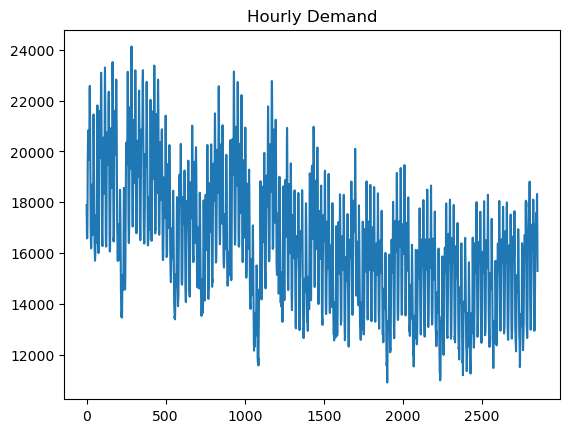

In [23]:
# You can see some trends in the dataset over time. You can also see periodicity.
plt.plot(df_hist_univar)
plt.title('Hourly Demand')
plt.show()

In [19]:
# It is a good idea to fix the random number seed to ensure our results are reproducible.
tf.random.set_seed(786)

In [20]:
# LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
# It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_hist_univar)

In [127]:
# Train - Test separation
# With time series data, the sequence of values is important. 
# A simple method that we can use is to split the ordered dataset into train and test datasets. 
# The code below calculates the index of the split point and separates the data into the training datasets 
# with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1894 933


In [68]:
# The LSTM network expects the input data (X) to be provided with a specific array structure 
# in the form of: [samples, time steps, features].
# We can write a simple function to convert our single column of data into a two-column dataset: 
# the first column containing this hour’s (t) electricity demand and the second column containing next hour’s (t+1) 
# electricity demand, to be predicted.
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# The function takes two arguments: the dataset, and the look_back, which is the number of previous time steps to use as 
# input variables to predict the next time period — in this case defaulted to 1.
# This will create a dataset where X is the demand at a given time (t) and Y is the demand at the next time (t + 1).

In [128]:
# reshape into X=t and Y=t+1
look_back = 24 # look back 2 days
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [129]:
# Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 
# We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:
# reshape input to be [samples, time steps, features]
# 1 stands for the time period between data.
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [28]:
# LTSM newtword design
# The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a 
# single value prediction. 
# The default sigmoid activation function is used for the LSTM blocks. 
# The network is trained for 100 epochs and a batch size of 1 is used.

# Predict more than 1 future value: https://stackoverflow.com/questions/69906416/forecast-future-values-with-lstm-in-python

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
#verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar per epoch, 2 = one line per epoch

In [148]:
model.save('lstm_model.h5')  # creates a HDF5 file. Load with from keras.models import load_model

In [130]:
# Once the model is fit, we can estimate the performance of the model on the train and test datasets. 
# This will give us a point of comparison for new models.
# Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units 
# as the original data -pre normalized data.

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions --> to see data on its original scale (pre-normalized)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

29/29 [==============================] - 0s 4ms/step
Train Score: 324.26 RMSE
Test Score: 412.96 RMSE


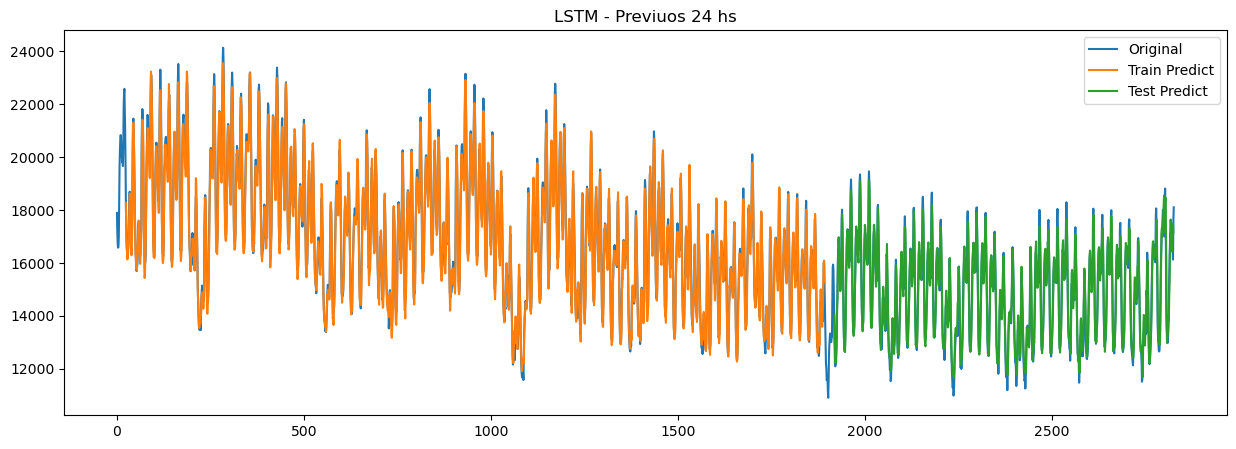

In [108]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('LSTM - Previuos 24 hs')
plt.legend()
plt.show()

## Predict Future Secuence of dates
You need to define the outputs as y[t: t + H] (instead of y[t] as in the current code) where y is the time series and H is the length of the forecast period (i.e. the number of days ahead that you want to forecast). 
You also need to set the number of outputs of the last layer equal to H (instead of equal to 1 as in the current code).

https://stackoverflow.com/questions/69906416/forecast-future-values-with-lstm-in-python

### Model Training

In [44]:
# [1] Get historic data: hourly demand till yesterday. Forcasting will start from today
database='user'
host='local_pgdb'
user='user'
password='admin'
port=5432
verbose = True
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port, verbose=verbose)
if process_ok:
    date = datetime.now().date()
    sql_query = """SELECT timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday 
                    FROM cammesa_db.hourly_demand 
                    WHERE timestamp <= '""" + date.strftime('%Y-%m-%d') +"'" +\
                """ORDER BY timestamp"""
    process_ok, error_txt, df_hist = pg_select_to_pandas(cursor, sql_query, verbose=True)
    if not process_ok:
        if verbose:
            print('INFO - nombre_de_proceso Error.' + error_txt)
df_hist

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 2854


,timestamp,hourly_demand,hourly_temp,day_of_week,is_holiday
0,2022-07-01 01:00:00,17891,8.800,4,0
1,2022-07-01 02:00:00,17206,8.700,4,0
2,2022-07-01 03:00:00,16732,8.900,4,0
3,2022-07-01 04:00:00,16578,8.700,4,0
4,2022-07-01 05:00:00,16607,8.700,4,0
...,...,...,...,...,...
2849,2022-10-27 20:00:00,18092,24.300,3,0
2850,2022-10-27 21:00:00,18322,22.100,3,0
2851,2022-10-27 22:00:00,17656,20.600,3,0
2852,2022-10-27 23:00:00,16551,20.100,3,0


In [45]:
# [2] Prepare Data. Normalize, re shape
# We are not interested in the date, given that each observation is separated by the same interval (hourly) 
# We build an univariate dataset:
df_hist_univar = df_hist[['hourly_demand']]
# LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
# It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(df_hist_univar)

In [46]:
# [3] Generate the input and output sequences
n_lookback = 48  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)
X = []
Y = []
for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])
X = np.array(X)
Y = np.array(Y)

In [47]:
# [4] fit the model
# It is a good idea to fix the random number seed to ensure our results are reproducible.
tf.random.set_seed(786)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

In [48]:
model.compile(loss='mean_squared_error', optimizer='adam')
print('WAIT until I fit model.') #11:23 - 11:35 ~ 12 min de ejecución
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

WAIT until I fit model.


In [49]:
# [5] Persist the model
model.save('lstm_24_model.h5')  # creates a HDF5 file. Load with from keras.models import load_model

In [50]:
# [6] Generate forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 798ms/step


<AxesSubplot: title={'center': 'Energy Demand Forecast'}, xlabel='timestamp'>

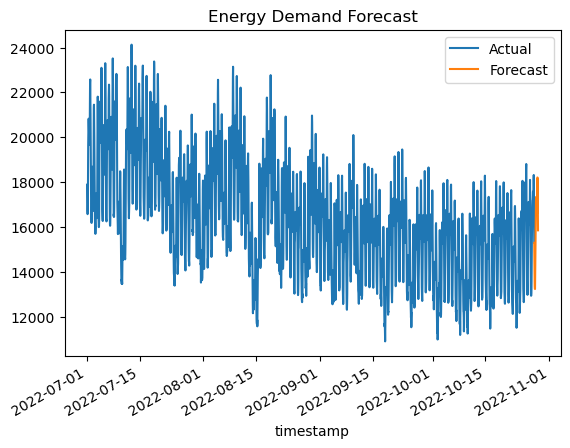

In [55]:
# [7] Plot
df_past = df_hist[['timestamp', 'hourly_demand']]
df_past.rename(columns={'hourly_demand': 'Actual'}, inplace=True)
#df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['timestamp', 'Actual', 'Forecast'])
df_future['timestamp'] = pd.date_range(start=df_past['timestamp'].iloc[-1] + pd.Timedelta(hours=1), freq='1H', periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('timestamp')

# plot the results
.plot(title='Energy Demand Forecast')

<AxesSubplot: title={'center': 'Energy Demand Forecast'}, xlabel='timestamp'>

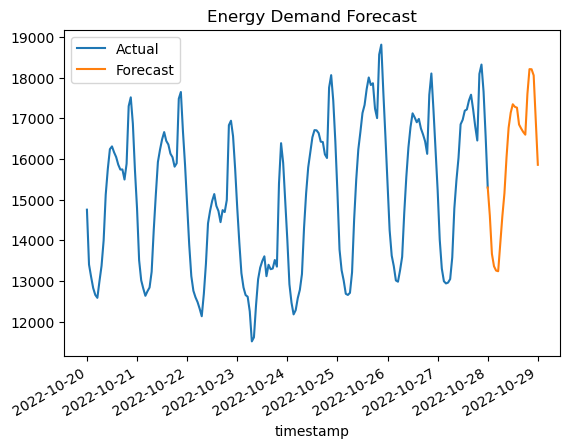

In [58]:
results = df_past.append(df_future).set_index('timestamp')

# plot the results
results.loc['2022-10-20': '2022-10-29'].plot(title='Energy Demand Forecast')

In [56]:
df_future

,timestamp,Actual,Forecast
0,2022-10-28 01:00:00,NaN,14606.607
1,2022-10-28 02:00:00,NaN,13667.178
2,2022-10-28 03:00:00,NaN,13362.022
3,2022-10-28 04:00:00,NaN,13256.080
4,2022-10-28 05:00:00,NaN,13240.139
5,2022-10-28 06:00:00,NaN,13909.004
6,2022-10-28 07:00:00,NaN,14592.232
7,2022-10-28 08:00:00,NaN,15158.960
8,2022-10-28 09:00:00,NaN,16041.835
9,2022-10-28 10:00:00,NaN,16768.105


## Routine for DAG
This routine reads history form DB (las "n_lookback" hours), predicts next "n_forecast" hours, using a pre-fit LSTM model, and records the results in de DB, to be consume by other apps (ex: Superset)

In [76]:
n_lookback = 48  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

def _calculate_hourly_demand_forecast(database, host, user, password, port, n_lookback=48, n_forecast=24, verbose=True):
    error_txt = ''
    process_ok = True
    verbose=True
    process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port, verbose=verbose)
    if not process_ok:
        if verbose:
            print('ERROR _calculate_hourly_demand_forecast calling subprocess: ' + error_txt)
    else:
        # [1] Get last record with history data: 
        sql_query = """SELECT MAX(timestamp) AS max_timestamp
                    FROM cammesa_db.hourly_demand 
                """
        process_ok, error_txt, df_last_time = pg_select_to_pandas(cursor, sql_query, verbose=True)
        if not process_ok:
            if verbose:
                print('ERROR nombre_del_modulo calling subprocess: ' + error_txt)
                cnxn.close()
        else:
            last_timestamp = df_last_time.max_timestamp[0]
            # [1] Get last n_lookback hours --> to predict next n_forecast hour demand
            sql_query = """SELECT timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday 
                        FROM cammesa_db.hourly_demand 
                        WHERE timestamp >= '""" + (last_timestamp+timedelta(hours=-n_lookback)).strftime('%Y-%m-%d %H:%M') +"'" +\
                    """AND timestamp <= '""" + last_timestamp.strftime('%Y-%m-%d %H:%M') +"'"+\
                    """ORDER BY timestamp"""
        process_ok, error_txt, df_lookback = pg_select_to_pandas(cursor, sql_query, verbose=True)
        if not process_ok:
            if verbose:
                print('ERROR nombre_del_modulo calling subprocess: ' + error_txt)
                cnxn.close()
        # [2] Prepare Data. Normalize, re shape
        # We are not interested in the date, given that each observation is separated by the same interval (hourly) 
        # We build an univariate dataset:
        df_hist_univar = df_lookback[['hourly_demand']]
        # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
        # It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
        scaler = MinMaxScaler(feature_range=(0, 1))
        y = scaler.fit_transform(df_hist_univar)
        # [3] Generate forecasts
        X_ = y[- n_lookback:]  # last available input sequence
        X_ = X_.reshape(1, n_lookback, 1)
        # Load pre-trained model
        model = load_model('lstm_24_model.h5')
        Y_ = model.predict(X_).reshape(-1, 1)
        Y_ = scaler.inverse_transform(Y_)
        # [4] Upsert data onto database
        df_future = pd.DataFrame(columns=['timestamp', 'hourly_demand_forecast'])
        df_future['timestamp'] = pd.date_range(start=df_lookback['timestamp'].iloc[-1] + pd.Timedelta(hours=1)
                                               , freq='1H', periods=n_forecast)
        df_future['hourly_demand_forecast'] = Y_.flatten()
        if verbose:
            print('INFO _calculate_hourly_demand_forecast: forecast calculated for next '+str(n_forecast)+' hours. Since: '+\
                 last_timestamp.strftime('%Y-%m-%d %H:%M'))
            df_future.hourly_demand_forecast = df_future.hourly_demand_forecast.astype(int)
            df_future['hourly_temp_forecast'] = np.nan
            df_future['day_of_week'] = df_future.timestamp.dt.dayofweek
            for index, row in df_future.iterrows():
                process_ok, error_txt, is_a_holiday = is_holiday(row['timestamp'], verbose=False)
                if not process_ok:
                    if verbose:
                        print('ERROR _calculate_hourly_demand_forecast calling submodule: '+error_txt)
                    cnxn.close()
                    break
                else:
                    df_future['is_holiday'] = is_a_holiday
            if process_ok:
                upsert_user=getpass.getuser()
                tup = [tuple(np.append(np.append([1002], r), [upsert_user, datetime.now(), upsert_user, datetime.now()])) \
                            for r in df_future.to_numpy()]
                sql = """INSERT INTO cammesa_db.hourly_demand_forecast
                        (region_code, timestamp, hourly_demand_forecast, hourly_temp_forecast, day_of_week, is_holiday
                        , create_user, create_date, update_user, update_date) VALUES %s 
                        ON CONFLICT (region_code, timestamp) DO UPDATE
                        SET hourly_demand_forecast=EXCLUDED.hourly_demand_forecast
                        , hourly_temp_forecast=EXCLUDED.hourly_temp_forecast
                        , day_of_week=EXCLUDED.day_of_week
                        , is_holiday=EXCLUDED.is_holiday, update_user=EXCLUDED.update_user, update_date=EXCLUDED.update_date;
                        """
                execute_values(cursor, sql, tup)
                cnxn.commit()
                print('INFO _calculate_hourly_demand_forecast - ' + str(len(tup)) + ' records were upserted. Table cammesa_db.hourly_demand_forecast.')
    return process_ok, df_last_time, df_lookback, df_future
process_ok, df_last_time, df_lookback, df_future = _calculate_hourly_demand_forecast(database, host, user, 
                                    password, port, n_lookback=48, n_forecast=24, verbose=True)

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 1
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 49
1/1 [==============================] - 1s 1s/step
INFO _calculate_hourly_demand_forecast: forecast calculated for next 24 hours. Since: 2022-10-28 12:00
INFO _calculate_hourly_demand_forecast - 24 records were upserted. Table cammesa_db.hourly_demand_forecast.


In [68]:
print(df_last_time.max_timestamp.values[0])
df_future

2022-10-28T12:00:00.000000000


,timestamp,hourly_demand_forecast
0,2022-10-28 13:00:00,17932.680
1,2022-10-28 14:00:00,17672.455
2,2022-10-28 15:00:00,18348.973
3,2022-10-28 16:00:00,17815.508
4,2022-10-28 17:00:00,17123.473
5,2022-10-28 18:00:00,16993.092
6,2022-10-28 19:00:00,17262.219
7,2022-10-28 20:00:00,17297.184
8,2022-10-28 21:00:00,17356.961
9,2022-10-28 22:00:00,17307.410


In [ ]:

        
        
        date = date.date()
        _request = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegionByFecha?fecha='+str(date)+'&id_region=1002'
        process_ok, error_txt, df_demand = _url_request_to_pandas(_request, verbose)
        if not process_ok:
            if verbose:
                print(error_txt)
                cnxn.close()
        else:
            df_demand.fecha = pd.to_datetime(df_demand.fecha.astype(str).str[:19], format='%Y-%m-%d %H:%M:%S')
            df_demand = df_demand[df_demand.fecha.dt.minute==0]
            if df_demand.shape[0]==0:
                if verbose:
                    print('INFO get_hourly_demand - No Data to upsert. Date: ' + str(date))
            else:
                # demand values can come as Nan --> exclude those records.
                df_demand.dropna(axis=0, subset=['dem'], inplace=True)
                df_demand.dem = df_demand.dem.astype(int)
                df_demand['day_of_week'] = df_demand.fecha.dt.dayofweek
                process_ok, error_txt, is_a_holiday = is_holiday(date, verbose=verbose)
                if not process_ok:
                    if verbose:
                        print(error_txt)
                    cnxn.close()
                else:
                    df_demand['is_holiday'] = is_a_holiday
                    tup = [tuple(np.append(np.append([1002], r), ['COLMO', datetime.now(), 'COLMO', datetime.now()])) \
                            for r in df_demand.to_numpy()]
                    sql = 'INSERT INTO cammesa_db.hourly_demand '+\
                        '(region_code, timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday, create_user, create_date, '+\
                        'update_user, update_date) VALUES %s ON CONFLICT (region_code, timestamp) DO UPDATE '+\
                        'SET hourly_demand=EXCLUDED.hourly_demand, hourly_temp=EXCLUDED.hourly_temp, day_of_week=EXCLUDED.day_of_week, '+\
                        'is_holiday=EXCLUDED.is_holiday, update_user=EXCLUDED.update_user, update_date=EXCLUDED.update_date;'
                    execute_values(cursor, sql, tup)
                    cnxn.commit()
                    print('INFO get_hourly_demand - ' + str(len(tup)) + ' records were upserted. Table cammesa_db.hourly_demand.')
        cnxn.close()

In [ ]:
database='user'
host='local_pgdb'
user='user'
password='admin'
port=5432
verbose = True

from keras.models import load_model
look_back = 24

error_txt = ''
process_ok = True
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port, verbose=verbose)
if not process_ok:
    if verbose:
        print('ERROR nombre_del_modulo calling subprocess: ' + error_txt)
else:
    # [1] Get last record with history data: 
    sql_query = """SELECT MAX(timestamp) AS max_timestamp
                    FROM cammesa_db.hourly_demand 
                """
    process_ok, error_txt, df_last_time = pg_select_to_pandas(cursor, sql_query, verbose=True)
    if not process_ok:
        if verbose:
            print('ERROR nombre_del_modulo calling subprocess: ' + error_txt)
    else:
        last_timestamp = df_last_time.max_timestamp[0]
        # [1] Get last 2 days --> to predict next hour demand
        sql_query = """SELECT timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday 
                        FROM cammesa_db.hourly_demand 
                        WHERE timestamp >= '""" + (last_timestamp+timedelta(hours=-look_back)).strftime('%Y-%m-%d %H:%M') +"'" +\
                    """AND timestamp <= '""" + last_timestamp.strftime('%Y-%m-%d %H:%M') +"'"+\
                    """ORDER BY timestamp"""
        process_ok, error_txt, df_look_back = pg_select_to_pandas(cursor, sql_query, verbose=True)
        if not process_ok:
            if verbose:
                print('ERROR nombre_del_modulo calling subprocess: ' + error_txt)


In [132]:
def create_dataset_forecast(dataset, look_back=1):
    dataX = []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    return np.array(dataX)

look_back = 24
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_prod = scaler.fit_transform(df_hist_univar[-look_back-1:])
X = create_dataset_forecast(dataset_prod, look_back=24)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
pred = model.predict(X)
Y = scaler.inverse_transform(pred)
X[0], len(X), pred, Y

1/1 [==============================] - 0s 34ms/step


(array([[0.95831189, 1.        , 0.79670612, 0.61005318, 0.21753302,
         0.10979585, 0.0655344 , 0.00514668, 0.        , 0.04803568,
         0.10482072, 0.28941499, 0.4422714 , 0.56596329, 0.65208441,
         0.71024189, 0.69291474, 0.67267113, 0.68673872, 0.6462515 ,
         0.62137588, 0.5920398 , 0.5393721 , 0.78812832]]),
 1,
 array([[0.73441297]], dtype=float32),
 array([[17263.895]], dtype=float32))

In [135]:
df_hist.timestamp.max()

Timestamp('2022-10-26 21:00:00')

In [38]:
sql_query = """SELECT MAX(timestamp) AS max_timestamp
                    FROM cammesa_db.hourly_demand 
                """
process_ok, error_txt, df_last_time = pg_select_to_pandas(cursor, sql_query, verbose=True)
sql_query, df_last_time

INFO pg_select_to_pandas: query executed Ok. Number of records returned: 1


('SELECT MAX(timestamp) AS max_timestamp\n                    FROM cammesa_db.hourly_demand \n                ',
   max_timestamp
 0    2022-10-28)

In [40]:
def create_dataset_forecast(dataset, look_back=1):
    dataX = []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    return np.array(dataX)

database='user'
host='local_pgdb'
user='user'
password='admin'
port=5432
verbose = True

from keras.models import load_model
error_txt = ''
process_ok = True
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password, port=port, verbose=verbose)
if not process_ok:
    if verbose:
        print('ERROR nombre_del_modulo calling subprocess: ' + error_txt)
else:
    # [1] Get last record with history data: 
    sql_query = """SELECT MAX(timestamp) AS max_timestamp
                    FROM cammesa_db.hourly_demand 
                """
    process_ok, error_txt, df_last_time = pg_select_to_pandas(cursor, sql_query, verbose=True)
    if not process_ok:
        if verbose:
            print('ERROR nombre_del_modulo calling subprocess: ' + error_txt)
    else:
        last_timestamp = df_last_time.max_timestamp[0]
        # [1] Get last 2 days --> to predict next hour demand
        look_back = 24
        sql_query = """SELECT timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday 
                        FROM cammesa_db.hourly_demand 
                        WHERE timestamp >= '""" + (last_timestamp+timedelta(hours=-look_back)).strftime('%Y-%m-%d %H:%M') +"'" +\
                    """AND timestamp <= '""" + last_timestamp.strftime('%Y-%m-%d %H:%M') +"'"+\
                    """ORDER BY timestamp"""
        process_ok, error_txt, df_look_back = pg_select_to_pandas(cursor, sql_query, verbose=True)
        # It is a good idea to fix the random number seed to ensure our results are reproducible.
        tf.random.set_seed(786)
        # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
        # It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. 
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(df_look_back[['hourly_demand']])
        X = create_dataset_forecast(dataset, look_back=24)
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
        model = load_model('lstm_model.h5')
        pred = model.predict(X)
        Y = scaler.inverse_transform(pred)
        df_look_back[['hourly_demand']], X[0], len(X), pred, Y

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 1
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 25


2022-10-28 03:55:33.185786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-28 03:55:33.186933: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-28 03:55:33.186998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (189fd90aa289): /proc/driver/nvidia/version does not exist
2022-10-28 03:55:33.191702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 594ms/step


In [41]:
df_look_back[['hourly_demand']], X[0], len(X), pred, Y

(    hourly_demand
 0           15237
 1           14018
 2           13306
 3           12994
 4           12940
 5           12961
 6           13047
 7           13579
 8           14785
 9           15475
 10          16029
 11          16852
 12          16965
 13          17188
 14          17219
 15          17439
 16          17581
 17          17220
 18          16802
 19          16455
 20          18092
 21          18322
 22          17656
 23          16551
 24          15298,
 array([[0.42679301, 0.20029729, 0.06800446, 0.01003344, 0.        ,
         0.0039019 , 0.01988109, 0.1187291 , 0.34280936, 0.47101449,
         0.5739502 , 0.72686734, 0.74786325, 0.78929766, 0.7950576 ,
         0.8359346 , 0.86231884, 0.7952434 , 0.71757711, 0.65310294,
         0.95726496, 1.        , 0.87625418, 0.67094017]]),
 1,
 array([[0.51149625]], dtype=float32),
 array([[15692.873]], dtype=float32))

In [146]:
look_back = 24
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_pred = scaler.fit_transform(df_test[-look_back-1:][['hourly_demand']])
X = create_dataset_forecast(dataset_pred, look_back=24)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
pred = model.predict(X)
Y = scaler.inverse_transform(pred)
df_test[-look_back-2:][['hourly_demand']], X[0], len(X), pred, Y

1/1 [==============================] - 0s 49ms/step


(      hourly_demand
 2821          16750
 2822          16605
 2823          16434
 2824          16127
 2825          17577
 2826          18103
 2842          14018
 2843          13306
 2844          12994
 2845          12940
 2827          12961
 2828          13047
 2829          13579
 2830          14785
 2831          15475
 2832          16029
 2833          16852
 2834          16965
 2835          17188
 2836          17219
 2837          17439
 2838          17581
 2839          17220
 2840          16802
 2841          16455
 2846          18092,
 array([[0.73794306, 0.70985861, 0.67673833, 0.61727678, 0.89812125,
         1.        , 0.20879334, 0.07088902, 0.01045904, 0.        ,
         0.0040674 , 0.02072439, 0.12376525, 0.35735038, 0.49099361,
         0.59829556, 0.75769901, 0.77958551, 0.82277745, 0.82878172,
         0.8713926 , 0.89889599, 0.8289754 , 0.74801472]]),
 2,
 array([[0.8870685 ],
        [0.87947476]], dtype=float32),
 array([[17519.934],
        [1

In [103]:
pred = [np.nan for i in range(0, look_back+1)] + [x[0] for x in trainPredict] + [np.nan for i in range(0, look_back+1)]+ [x[0] for x in testPredict]
len(pred)

2827

In [ ]:
df_plot = df_hist.copy()
df_plot['pred']

In [113]:
len(dataset)

2827

In [59]:
trainPredict, len(trainPredict), len(testPredict), 1894-24, 933-24
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#trainPredictPlot[:30]

# Database Build Code
Code to populate Database. Run it only once.

In [11]:
#### Load Regions Table:
#### WARNING: tree first node with father id = 0
_request = 'https://api.cammesa.com/demanda-svc/demanda/RegionesDemanda'
process_ok, error_txt, df = _url_request_to_pandas(_request)
if not process_ok:
    print(error_txt)
    raise ValueError(error_txt)
# Adjunst types:
df.fillna(0, inplace=True) 
df.idPadre = df.idPadre.astype(int)
df = df.drop(columns=['minEscala', 'maxEscala', 'idRge'])
#print(df.dtypes)
#df.head()
process_ok, cnxn, cursor = build_postgres_cnxn(database='user', host='local_pgdb', user='user', password='admin', port=5432)
if process_ok:
    #https://stackoverflow.com/questions/45285244/convert-a-dataframe-to-list-of-tuples
    #execute_values(cursor, "INSERT INTO test (id, v1, v2) VALUES %s", [tuple(r) for r in df.to_numpy()])
    tup = [tuple(np.append(r, ['COLMO', datetime.now(), 'COLMO', datetime.now()])) for r in df.to_numpy()]
    execute_values(cursor, "INSERT INTO cammesa_db.regions (region_id, region_desc, parent_id, region_code, create_user, create_date, update_user, update_date) VALUES %s"
                   , tup)
    cnxn.commit()
    cnxn.close()

INFO api_request_to_pandas: API request executed Ok. Number of records returned: 36
INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok


# Test Code

In [48]:
sql_query = 'SELECT * FROM cammesa_db."regions"'
process_of, df_regions = pg_query_regions_to_pandas(database='user', host='local_pgdb', user='user', password='admin', port=5432, sql_query=sql_query)
df_regions.head(2)

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 36


,region_id,region_code,region_desc,parent_id,create_user,create_date,update_user,update_date
0,535042,418,NEA,535052,COLMO,2022-10-23 19:46:15.344908,COLMO,2022-10-23 19:46:15.344910
1,535043,419,NOA,535052,COLMO,2022-10-23 19:46:15.344945,COLMO,2022-10-23 19:46:15.344946


## Demanda

In [23]:
process_ok, cnxn, cursor = build_postgres_cnxn(database='user', host='local_pgdb', user='user', password='admin', port=5432)
if not process_ok:
    print(error_txt)
    raise ValueError(error_txt)
else:
    dt_ini = pd.to_datetime("2022-07-01").date()
    for i in range((datetime.now().date()-dt_ini).days):
        date = dt_ini + timedelta(days=i)
        _request = 'https://api.cammesa.com/demanda-svc/demanda/ObtieneDemandaYTemperaturaRegionByFecha?fecha='+str(date)+'&id_region=1002'
        process_ok, error_txt, df_demand = _url_request_to_pandas(_request)
        if not process_ok:
            print(error_txt)
            cnxn.close()
            raise ValueError(error_txt)
        else:
            df_demand.fecha = pd.to_datetime(df_demand.fecha.astype(str).str[:19], format='%Y-%m-%d %H:%M:%S')
            # demand values can come as Nan --> exclude those records.
            df_demand.dropna(axis=0, subset=['dem'], inplace=True)
            df_demand.dem = df_demand.dem.astype(int)
            df_demand['day_of_week'] = df_demand.fecha.dt.dayofweek
            process_ok, error_txt, is_a_holiday = is_holiday(date)
            if not process_ok:
                print(error_txt)
                cnxn.close()
                raise ValueError(error_txt)
            else:
                df_demand['is_holiday'] = is_a_holiday
                tup = [tuple(np.append(np.append([1002], r), ['COLMO', datetime.now(), 'COLMO', datetime.now()])) \
                       for r in df_demand[df_demand.fecha.dt.minute==0].to_numpy()]
                """insert into segments(id, departure_hour) 
values 
    (1153, 2), 
    (1156, 4), 
    (1154, 2) 
on conflict do update set 
    departure_hour = excluded.departure_hour;"""
                execute_values(cursor, "INSERT INTO cammesa_db.hourly_demand (region_code, timestamp, hourly_demand, hourly_temp, day_of_week, is_holiday, create_user, create_date, update_user, update_date) VALUES %s"
                   , tup)
                cnxn.commit()
    cnxn.close()
# We are only processing data from the hour (because history is on a hourly basis):
df_demand[df_demand.fecha.dt.minute==0]

INFO Module build_postgres_cnxn: DB Connection to host local_pgdb Ok
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 288
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 19
INFO is_holiday. URL request for 2022-07-01 Ok.
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 288
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 19
INFO is_holiday. URL request for 2022-07-02 Ok.
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 288
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 19
INFO is_holiday. URL request for 2022-07-03 Ok.
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 288
INFO api_request_to_pandas: API request executed Ok. Number of records returned: 19
INFO is_holiday. URL request for 2022-07-04 Ok.
INFO api_request_to_pandas: API request executed Ok. Number of 

,fecha,dem,temp,day_of_week,is_holiday
11,2022-10-25 01:00:00,13774,19.100,1,0
23,2022-10-25 02:00:00,13264,18.400,1,0
35,2022-10-25 03:00:00,13011,18.600,1,0
47,2022-10-25 04:00:00,12685,18.700,1,0
59,2022-10-25 05:00:00,12657,18.300,1,0
71,2022-10-25 06:00:00,12709,18.000,1,0
83,2022-10-25 07:00:00,13213,18.600,1,0
95,2022-10-25 08:00:00,14513,19.900,1,0
107,2022-10-25 09:00:00,15491,22.300,1,0
119,2022-10-25 10:00:00,16235,23.700,1,0


In [27]:
cnxn.close()

In [12]:
#cursor.execute('SELECT * FROM public."historylastfm001" LIMIT 10')
cursor.execute('SELECT datname FROM pg_database')
data = cursor.fetchall()
pd.DataFrame(data=data)

,0
0,postgres
1,user
2,template1
3,template0


In [ ]:
conn.close()

In [33]:
response.status

200